# Harris Corner Detector.
Task:

Your task is to create a Python Class `HarrisCorner` that contains the `det_coords` method to return the detected coordinates in the image. The returned coordinates should be in the form of an array N x 2, where N is the number of coordinates and each coordinate is given as position in row/column order in the image matrix. (Note that the `det_coords` method will require a threshold value as an input argument)

Your should also make the corner response function available as an instance variable with the name `corner_response`.  This will allow you to determine if the corner response is being determined correctly. The corner response can be determined by calling a method within the class on intialisation.








#Notes on Implementing the Harris Algorithm

Corners are detected in local image regions using the corner reponse function $R=Det(M)-\alpha Trace(M)^2$ which is formed from the Determinate and Trace of the matrix $ M = \begin{vmatrix} A & C \\ C & B \end{vmatrix}$. M is referred to as the second moment matrix (slide 11).

> The second moment matrix nominally consists of the 2nd order partial derivatives of change in intensity of the image e.g. $A = \frac{\partial^2{E_{0,0}}}{\partial{x}^2}$.

> The 2nd order partial derivatives can be approximated from products of partial derivatives of the image convolved with a small gaussian window $\frac{\partial^2{E_{0,0}}}{\partial{x}^2} = \sum_{u,v} 2 w_{u,v} (\frac{\partial{I_{u,v}}}{\partial{x}}\frac{\partial{I_{u,v}}}{\partial{x}} )= X^2\circledast W$ . (slide 9)

> The first order image derivatives can be obtained using any finite difference approximate to the derivative or with by filtering the image with the x and y sobel kernels $\frac{\partial{I_{u,v}}}{\partial{x}}= X=I_{u,v}\circledast x_{sobel}$ (slide 7)

In order to be able to form the components of the matrix M we will carry out the following coding steps:

1.   Create a function to output the gradient (sobel) kernel. Also complete a function to output the Gaussian kernel. (Note all kernels are 2d)
2.   Determine estimates of 1st order partial derivatives of the image $(\frac{\partial{I_{u,v}}}{\partial{x}},\frac{\partial{I_{u,v}}}{\partial{y}})$ by convolving the image with the gradient (sobel or prewitt) kernels.
3.   Obtain the products of 1st order partial derivatives (e.g. $XY= \frac{\partial{I_{u,v}}}{\partial{x}} \frac{\partial{I_{u,v}}}{\partial{y}}$).
4.  Convolve the products of 1st order partial derivatives with the guassian kernel to obtain components of the second moment matrix $M = \begin{pmatrix}
A & C \\
C & B
\end{pmatrix}$ (e.g. $ A = X^2 \circledast W$).
5.  The corner response function is determined as the difference (with a scaling factor $\alpha$ between the Determinant and trace of the matrix M $(R=Det(M)-\alpha Trace(M)^2)$. As shown in the slides, the Determinant and Trace can be easily found from the elements of the matix $M$.
> $Det(M) = AB-C^2$

>> $Trace(M) = A+B$

6. 6. You can return the coner response function (for display) by assigning the corner response to an instance variable with the name `corner_response`. Ensure that the corner response function makes sense, do the maxima and minima appear where you expect them?

3. Determine the coordinates of the local maxima of the response function.
 * The row/column coordinates of local maxima in the image can be obtained using the peak_local_max method as shown in the [scikit learn example](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_peak_local_max.html).
  * However If we apply peal_local_max directly on the response function we will obtain a large number of maxima corresponding to small variations in the flat regions. Not just the corner regions.
  * Therefore we can use a threshold value (given as an input to the `det_coords` method) and find where the pixel values are greater than the thresold. Using a greater or less than operation (between threshold and image) produces a binary value at each pixel. We then need to multiply this binary result by the original response function and we will be left with only the peaks of the response function.

Hints:
 * It is best to consistently use numpy methods (arrays) to complete this lab.
 * In order to define the [sobel](https://en.wikipedia.org/wiki/Sobel_operator) kernel, the [numpy array method](https://numpy.org/doc/stable/reference/generated/numpy.array.html) can be used (A 2D array will be required).
 * The gaussian kernel can be defined in exactly the same way as seen in a previous lab (i.e. creating a 1D array over a range of pixels and using outer product to create a 2D array)
 * In order to perform 2D convolution between the image (or other array) and the kernels, the [scipy convolve 2d](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html) method can be used.
 * **If you use AI to generate code ensure that it is consistent with the methodology outlined above. The generated code may be slightly different or more compact by combining steps.**

# HouseKeeping:
 Load test image, import required packages

In [41]:

import numpy as np
from scipy import signal
import cv2
import matplotlib.pyplot as plt
import urllib.request
import os
from urllib.parse import urlparse
from skimage.feature import peak_local_max

In [42]:
# function to read images from Web addresses.
def download_image(url, save_path):
    """
    Downloads an image from a URL and saves it to disk.
    If the image already exists at the specified path, it is read from disk.

    Args:
        url (str): URL of the image.
        save_path (str): Path to save the image on disk.

    Returns:
        None
    """
    # Parse the URL to get the filename
    filename = os.path.basename(urlparse(url).path)
    image_path = os.path.join(save_path, filename)

    # Check if the image already exists
    if os.path.exists(image_path):
        print(f"Image already exists at {image_path}. Reading from disk.")
        image = cv2.imread(image_path)
    else:
        print(f"Downloading image from {url}...")
        resp = urllib.request.urlopen(url)
        temp_image = np.asarray(bytearray(resp.read()), dtype="uint8")
        temp_image = cv2.imdecode(temp_image, cv2.IMREAD_COLOR)
        temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2RGB)
        print(f"Image downloaded and saved at {image_path}.")
        cv2.imwrite(image_path, temp_image)
        image = cv2.imread(image_path)
    return image

# Function to normalise images for display
def norm_img(ip_img):
   norm_img = ip_img-np.min(ip_img)
   norm_img = norm_img/(np.max(ip_img)-np.min(ip_img))
   return norm_img

In [43]:


def rescale_crop(image):
   # Rescale & Crop Image
   HW_trg =512
   img_H = np.shape(image)[0]
   img_W = np.shape(image)[1]
   min_dim_size = min(img_H,img_W)
   scale_fac = HW_trg/min_dim_size
   scale_img_H = int(np.ceil(np.shape(image)[0]*scale_fac))
   scale_img_W = int(np.ceil(np.shape(image)[1]*scale_fac))
   rescale_image = cv2.resize(image, (scale_img_W,scale_img_H), interpolation = cv2.INTER_AREA)
   crop_image = rescale_image[0:HW_trg, 0:HW_trg]
   return crop_image

# Create Class
Include code for the HarrisCorner Class in the code cell below.

In [44]:
##################################################################
# Create a Harris Corner Detector
##################################################################
class HarrisCorner:


   def __init__(self,image,sigma,alpha=0.2):
      self.image = image
      self.sigma = sigma
      self.alpha = alpha
      self.sx, self.sy = self.gradient_kernels()
      self.gaussian = self.gaussian_kernel(sigma)
      self.A,self.B,self.C=self.derivatives()
      self.corner_response = self.calculate_corner_response()


   def gradient_kernels(self):
        x = np.array([[-1, 0, 1],
                      [-2, 0, 2],
                      [-1, 0, 1]])

        y = np.array([[1,  2, 1],
                      [0,  0, 0],
                      [-1,-2,-1]])
        return x, y


   def gaussian_kernel(self, sigma):
        rng = int(6*sigma + 1)
        x = np.arange(-rng, rng + 1)
        G = (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-(x**2) / (2 * sigma**2))
        Gaussian2d = np.outer(G, G)
        return Gaussian2d

   def derivatives(self):
        pdx = signal.convolve2d(self.image, self.sx, mode='same', boundary='symm')
        pdy = signal.convolve2d(self.image, self.sy, mode='same', boundary='symm')
        x = np.multiply(pdx, pdx)
        y = np.multiply(pdy, pdy)
        xy = np.multiply(pdx, pdy)
        A = signal.convolve2d(x, self.gaussian, mode='same', boundary='symm')
        B = signal.convolve2d(y, self.gaussian, mode='same', boundary='symm')
        C = signal.convolve2d(xy, self.gaussian, mode='same', boundary='symm')
        return A, B, C

   def calculate_corner_response(self):
        R = ((self.A*self.B)-(self.C**2)) - self.alpha * ((self.A + self.B) ** 2)
        return R


   def det_coords(self, threshold_val=80):
        threshold = np.where(self.corner_response > threshold_val, self.corner_response, 0)
        cpoints = peak_local_max(threshold)
        return cpoints

 # Evaluate

 Instantiate Class and Mark Coordinates on Image

Image already exists at ./10x10_checkered_board.png. Reading from disk.


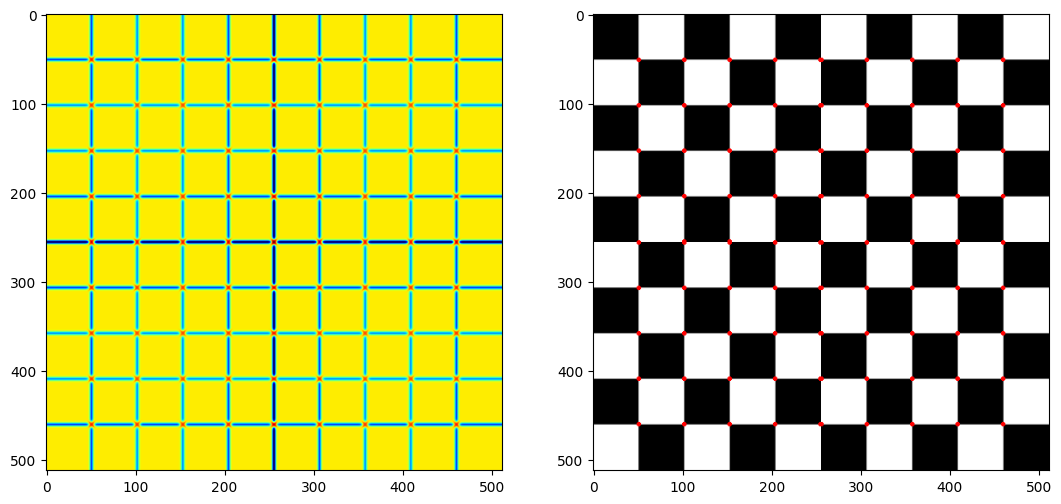

In [45]:
if __name__ == "__main__":
  # Load Image (good practice to re-load image between trials to remove old points)
  image_url = "https://github.com/tonyscan6003/etivities/blob/main/10x10_checkered_board.png?raw=true"
  image = download_image(image_url,save_path="./")
  crop_image = rescale_crop(image)
  input_image= cv2.cvtColor(crop_image, cv2.COLOR_BGR2GRAY)

  # Instantiate class
  hc = HarrisCorner(input_image,2,0.2)

  # Call Method to detect coordinates (automatically calls other methods)
  coordinates = hc.det_coords(80)
  response_fun = hc.corner_response

  # Mark coordinates on image
  for xy_pos in coordinates:
      cv2.circle(crop_image, (xy_pos[1],xy_pos[0]), 1, (255,0,0),thickness=2)

  # Plot image.
  fig = plt.figure(figsize=(20,10))
  def plot_filter(A,i):
      ax = fig.add_subplot(1,3, i)
      ax.imshow(A,'jet')
  plot_filter(norm_img(response_fun),1)
  plot_filter(crop_image,2)